In [2]:
import torch

# 1. Basic

## 1.1 Torch

In [14]:
x = torch.arange(1,20,2) #range. step=2
print(x,
x.shape,  #元素总数
x.numel(), # number of element
x.reshape(2,5), #相乘==元素数量
torch.zeros((2,2,2)),
torch.ones((2,3,4)).shape,
sep='\n')

tensor([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])
torch.Size([10])
10
tensor([[ 1,  3,  5,  7,  9],
        [11, 13, 15, 17, 19]])
tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])
torch.Size([2, 3, 4])


In [30]:
x = torch.arange(12, dtype=torch.float32).reshape(3,4)
y = torch.tensor([[1,2,3,4], [5,6,7,8], [4,3,2,1]])
print(
    torch.cat((x,y), dim=0).shape, torch.cat((x,y), dim=1).shape,
    x.sum(), 
    x[-1], # 最后一行
    x[1:3,],
    x[0:2,::],
sep='\n')

torch.Size([6, 4])
torch.Size([3, 8])
tensor(66.)
tensor([ 8.,  9., 10., 11.])
tensor([[ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])
tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])


In [ ]:
# broadcasting mechanism
a = torch.arange(3).reshape((3,1))
b = torch.arange(2).reshape((1,2))
a, b
a + b #!

tensor([[0, 1],
        [1, 2],
        [2, 3]])

## 1.2 Data Processing

In [32]:
import os, pandas as pd

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
file = os.path.join('..', 'data', 'house_tiny.csv')
with open(file, 'w') as f:
    f.write('NumRooms, Alley, Price\n')
    f.write('NA, Pave, 127500\n')
    f.write('2,NA,10600\n')

data = pd.read_csv(file)
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,10600


In [35]:
# missing data
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]
inputs

,NumRooms,Alley
0,NaN,Pave
1,2.0,NaN


## 1.3 Grad

In [20]:
x = torch.arange(4.0)
x.requires_grad_(True)
x.grad

In [21]:
y = 2 * torch.dot(x,x)
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [14]:
x.grad.zero_()
y = x.sum().backward()
x.grad

tensor([1., 1., 1., 1.])

In [24]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad == d / a

tensor(True)

# 2. Linear Regression

## 2.1 手搓

In [32]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

features: tensor([-1.9059, -0.0791]) 
label: tensor([0.6689])


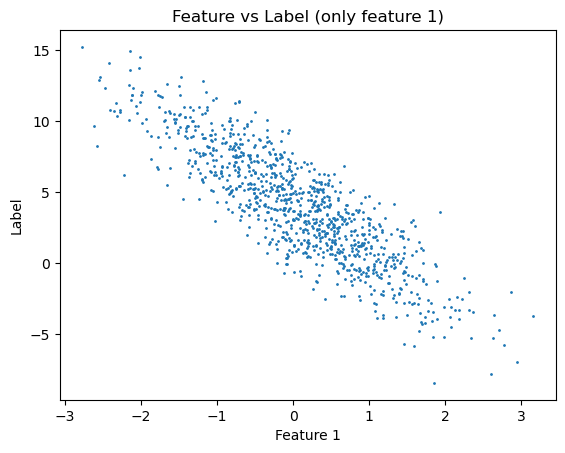

In [45]:
# 构造数据集

def synthetic_data(w, b, num_examples):
    '''
    生成 y = Xw + b
    x.shape = (num_examples, len(w))
    y(output) = (num_examples, 1)
    '''
    X = torch.normal(0, 1, (num_examples, len(w))) # x变成长度为w的数值
    y = torch.matmul(X,w) + b # y = Xw + b
    y += torch.normal(0, 0.01, y.shape) # y = Xw + b + e add random noise
    return X, y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])

# Visualize
plt.scatter(features[:, 1].numpy(), labels.numpy(), s=1)
plt.xlabel('Feature 1')
plt.ylabel('Label')
plt.title('Feature vs Label (only feature 1)')
plt.show()

In [68]:
# Data iter 

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for x, y in data_iter(batch_size, features, labels):
    print(x, '\n', y)
    break

tensor([[-0.3614,  0.2485],
        [-0.3003, -2.0552],
        [ 0.2149, -1.5506],
        [ 0.9829, -0.0128],
        [ 1.8659, -1.0553],
        [-0.8009,  0.9565],
        [ 0.0916, -1.1183],
        [-1.2005,  1.0100],
        [-1.4263, -0.1418],
        [-0.9924,  0.5502]]) 
 tensor([[ 2.6368],
        [10.5714],
        [ 9.9070],
        [ 6.1955],
        [11.5150],
        [-0.6801],
        [ 8.1846],
        [-1.6174],
        [ 1.8274],
        [ 0.3408]])


In [75]:
# initialize
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [76]:
# model
def linreg(X, w, y):
    return torch.matmul(X, w) + b

# loss
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

# optimalize - 随机梯度下降 Stochastic Gradient Descent
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 这段不参与反向传播计算图的构建
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [83]:
# training

lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # l.shape = (batch_size, 1)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {train_l.mean():.6f}')

epoch 1, loss 0.349376
epoch 2, loss 0.051875
epoch 3, loss 0.007759
epoch 4, loss 0.001198
epoch 5, loss 0.000222
epoch 6, loss 0.000075
epoch 7, loss 0.000053
epoch 8, loss 0.000050
epoch 9, loss 0.000049
epoch 10, loss 0.000049


In [84]:
# Compare
print(f'true_w: {true_w} \n w: {w.reshape(true_w.shape)}')
print(f'true_b: {true_b} \n b: {b}')

true_w: tensor([ 2.0000, -3.4000]) 
 w: tensor([ 1.9990, -3.3999], grad_fn=<ViewBackward0>)
true_b: 4.2 
 b: tensor([4.1997], requires_grad=True)


## 2.2 调api

In [87]:
from torch.utils import data

# Create dataset
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [89]:
# Data loader
def load_array(data_array, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_array)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-1.7619, -0.1383],
         [ 1.3247,  1.8869],
         [ 2.0361, -0.5793],
         [-0.2849,  0.0429],
         [ 0.4102,  0.1315],
         [ 0.4299,  1.0352],
         [-0.4516,  1.7103],
         [ 1.0572, -0.0455],
         [-2.0566, -0.1985],
         [ 0.5684, -0.5029]]),
 tensor([[ 1.1330],
         [ 0.4250],
         [10.2520],
         [ 3.4935],
         [ 4.5921],
         [ 1.5322],
         [-2.5277],
         [ 6.4609],
         [ 0.7507],
         [ 7.0231]])]

In [92]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0, 0.01) #.normal_(mean, std) 初始化权重
net[0].bias.data.fill_(0) # 把偏置 bias 全部设置为 0（常见做法）， fill_表示in place

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

In [93]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.608218
epoch 2, loss 0.011895
epoch 3, loss 0.000345
epoch 4, loss 0.000109
epoch 5, loss 0.000104


# 3. Softmax

## 3.1 Fashion_MNIST

In [3]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
# Use FashionMNIST
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../fashionMnist', train=True, transform=trans, download=True)
mnist_eval = torchvision.datasets.FashionMNIST(root='../fashionMnist',train=False, transform=trans, download=True)

print(
    len(mnist_train),
    len(mnist_eval),
    f'Single image shape: {mnist_train[0][0].shape}',
    sep='\n'
)

60000
10000
Single image shape: torch.Size([1, 28, 28])


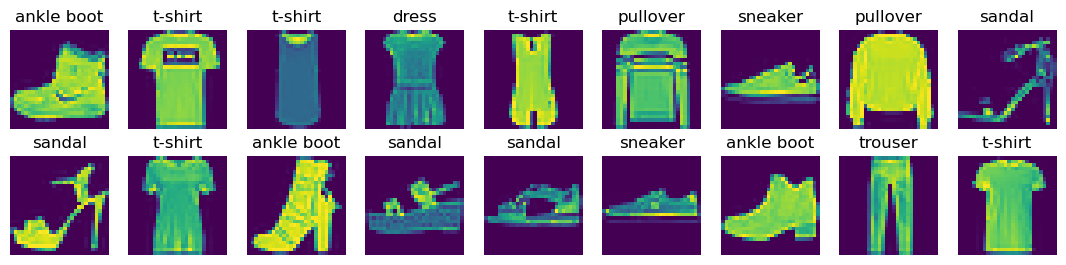

In [6]:
def get_fashion_mnist_labels(labels):
    text = [
        't-shirt',     # 0
        'trouser',     # 1
        'pullover',    # 2
        'dress',       # 3
        'coat',        # 4
        'sandal',      # 5
        'shirt',       # 6
        'sneaker',     # 7
        'bag',         # 8
        'ankle boot'   # 9
    ]
    return [text[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(num_rows*num_cols):
        if i < len(imgs):
            ax = axes[i]
            ax.imshow(imgs[i], cmap='viridis')
            ax.axis('off')
            if titles:
                ax.set_title(titles[i])
        else:
            axes[i].axis('off')
    plt.show()

X, y=next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [7]:
# CPU性能测试
import time

batch_size = 256
WORKERS=4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=WORKERS)
start = time.time()
for X,y in train_iter:
    continue
end = time.time()
f'timecost: {end-start:.6f} sec'

'timecost: 6.097439 sec'

## 3.2 Softmax

In [8]:
# real dataloader

batch_size = 256
WORKERS=4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../fashionMnist', train=True, transform=trans, download=True)
    mnist_eval = torchvision.datasets.FashionMNIST(root='../fashionMnist',train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=WORKERS), 
            data.DataLoader(mnist_eval, batch_size, shuffle=True, num_workers=WORKERS),
            )

In [9]:
# softmax
train_iter, eval_iter = load_data_fashion_mnist(batch_size=256)

# flatten tensor: 28*28 = 784
num_inputs = 784 # 图片（28*28 resolution）
num_outputs = 10 # 标签（10类）

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [10]:
'''
X shape: (batch_size, 1, 28, 28) --> reshape (batch_size, 784)
W shape: (784, 10)
b shape: (10,)
torch.matmul(X_reshaped, W) --> (batch_size, 10) 
'''
# 手搓
def softmax(X):
    x_exp = torch.exp(X)
    partition = x_exp.sum(1, keepdim=True) # 在10个labels上求和
    return x_exp / partition

X = torch.normal(0, 1, (2,5))
x_prob = softmax(X)
x_prob, x_prob.sum(1)

def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

# torch的类实现
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear = torch.nn.Linear(num_inputs, num_outputs)
    def forward(self, X):
        X = X.reshape(-1, W.shape[0])
        return softmax(self.linear(X))


In [11]:
'''
y = tensor([0, 2])
y_hat = tensor([[0.1, 0.3, 0.6], [0.2, 0.4, 0.4]])
y_hat[[0,1], y] 即选出 i 样本被预测对的那个的数值
fancy indexing：对于第 i 个样本，从它预测的所有类别中取出 y[i] 所对应的那个值。
'''

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])


def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 每个样本中预测概率最大的类别
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())/len(y) #预测对的总数

def eval_accu(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2) # 统计预测正确样本数和总样本数，两个metric
    for X,y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)] # *args 代表“任意多个位置参数”
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# softmax train 
from tqdm import tqdm 

def train_epoch(net, train_iter, loss, optimizer, epoch, num_epochs):
    '''
    metric: (loss, accuracy, number of elements)
    '''
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3) 
    for X,y in tqdm(train_iter, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        y_hat = net(X)
        l = loss(y_hat, y).mean()
        if isinstance(optimizer, torch.optim.Optimizer):
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            metric.add(
                l.item()*y.numel(), accuracy(y_hat, y), y.numel()
            )
        else:
            l.sum().backward()
            optimizer(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0]/metric[2], metric[1]/metric[2]

def train(net, train_iter, eval_iter, loss, num_epochs, optimizer):
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, optimizer, epoch, num_epochs)
        eval_acc = eval_accu(net, eval_iter)
        train_loss, train_acc = train_metrics
        print(f"Epoch {epoch+1}: loss {train_loss:.4f}, train acc {train_acc:.3f}, eval acc {eval_acc:.3f}")

NUM_EPOCHS = 10
net = SoftmaxRegression(num_inputs, num_outputs)
train(net, train_iter, eval_iter, cross_entropy, num_epochs=NUM_EPOCHS, optimizer=torch.optim.SGD(net.parameters(), lr=0.01))


Epoch 1: loss 1.3741, train acc 0.002, eval acc 0.003


Epoch 2: loss 0.9116, train acc 0.003, eval acc 0.003


Epoch 3: loss 0.7983, train acc 0.003, eval acc 0.003


Epoch 4: loss 0.7390, train acc 0.003, eval acc 0.003


Epoch 5: loss 0.7001, train acc 0.003, eval acc 0.003


Epoch 6: loss 0.6718, train acc 0.003, eval acc 0.003


Epoch 7: loss 0.6498, train acc 0.003, eval acc 0.003


Epoch 8: loss 0.6320, train acc 0.003, eval acc 0.003


Epoch 9: loss 0.6174, train acc 0.003, eval acc 0.003


Epoch 10: loss 0.6049, train acc 0.003, eval acc 0.003
